# Приоритизация гипотез. Анализ А/В- теста.

Для увеличения выручки нашего интернет-магазина совместно с отделом маркетинга подготовили список гипотез, которые нам необходимо приоритезировать, запустить А/В-тест, проанализировать результаты и внести предложения.

### 1. Описание данных

#### 1.1 Описание данных гипотез

1. `Hypothesis` — краткое описание гипотезы;
2.`Reach` — охват пользователей по 10-балльной шкале;
3.`Impact` — влияние на пользователей по 10-балльной шкале;
4. `Confidence` — уверенность в гипотезе по 10-балльной шкале;
5. `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


Наша задача: приоритизировать гипотезы. Выполнять это будем при помощи фреймвокров ICE и RICE, посмотрим,изменится ли последовательность приоритизации гипотез взависимости от метода и ,если необходимо, разберемся почему.


#### 1.2 Описание данных для Анализ A/B-теста

Файл ` /datasets/orders.csv.` 
1. `transactionId` — идентификатор заказа;
2.`visitorId` — идентификатор пользователя, совершившего заказ;
3.`date` — дата, когда был совершён заказ;
4.`revenue` — выручка заказа;
5.`group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv.`

1. `date` — дата;
2.`group` — группа A/B-теста;
3.`visitors` — количество пользователей в указанную дату в указанной группе A/B-теста 

   A/B-тест проведен, результаты получены, они находятся в следующих файлах `/datasets/orders.csv` и `/datasets/visitors.csv.` 


   Наша задача: проанализировать A/B-тест, а именно построим 


* график кумулятивной выручки по группам. 
* график кумулятивного среднего чека по группам. 
* график относительного изменения кумулятивного среднего чека группы B к группе A. 
* график кумулятивной конверсии по группам. 
* график относительного изменения кумулятивной конверсии группы B к группе A. 
* точечный график количества заказов по пользователям. 
* посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберем границу для определения аномальных пользователей.  
* точечный график стоимостей заказов.  
   Затем посчитаем:
* 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.
* статистическую значимость различий в конверсии между группами по «сырым» данным. 
* статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 
* статистическую значимость различий в конверсии между группами по «очищенным» данным. 
* статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.  

  По каждому из выше перечисленных пунктов мы сделаем  отдельные выводы и предположения, после чего примем финальное решение: либо остановим тест, выявив победу одной из групп или же наоборот установив, что различий нет, либо продолжим тест.  





### 2. Импортируем библиотеки.

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import scipy.stats as stats

import warnings
register_matplotlib_converters()

In [2]:
try:
    hypothesis = pd.read_csv('C:\\Users\\Admin\\Documents\\Yandex.practicum\\Project\\AB test\\hypothesis.csv')
    orders = pd.read_csv('C:\\Users\\Admin\\Documents\\Yandex.practicum\\Project\\AB test\\orders.csv')
    visitors = pd.read_csv('C:\\Users\\Admin\\Documents\\Yandex.practicum\\Project\\AB test\\visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')


### 3. Приоритизация гипотез

In [4]:
# выводим общую информацию по датафрейму
pd.options.display.max_colwidth = 100
hypothesis.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


В названии колонок применен верхний регистр для первых букв, заменим его для удобства. Так как гипотез не много, всего 9, визуально проверили, все они уникальны.



In [5]:
# замена на нижний регистр
hypothesis.columns = hypothesis.columns.str.lower()

In [6]:
# выводим общую информацию по датафрейму `hypothesis`
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В датафрейме у нас 5 колонок, замена регистра прошла успешно, 9 строк, пропусков нет.

In [7]:
# посчитаем ICE
hypothesis['ICE'] = round((hypothesis['impact']* hypothesis['confidence'])/hypothesis['efforts'],2)
display(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))


,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее эффективные гипотезы по ICE: 8,0,7,6

In [8]:
# посчитаем RICE
hypothesis['RICE'] = round((hypothesis['reach']*hypothesis['impact']* hypothesis['confidence'])/hypothesis['efforts'],2)
display(hypothesis[['hypothesis', 'RICE']]. sort_values(by='RICE', ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средни...",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конве...",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее эффективные гипотезы по RICE: 7,2,0,6

#### 3.1 Вывод 

Всего у нас 9 гипотез, для приоритизации мы применили фреймворки ICE и RICE, получили разные списки гипотез, так первая гипотеза по RICE 7 сместила 8 гипотезу за счет высокого параметра Reach, который равен 10, гипотеза под номером 2 появилась так же за счет относительно высокого показаетля Reach 8 и низкого Efforts, равному 3.

### 4. Анализ A/B-теста

In [9]:
# выведим 5 первых строк датафрейма orders
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [10]:
# смотрим общую информаицю по orders
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


В датафрейме у нас 5 колонок, названия нас устраивают, менять ничего не будем, пропусков нет, заменим тип данных в `date`

In [11]:
## проверим на дубликаты
orders.duplicated().sum()

0

Отлично, дубликатов нет.

In [12]:
# выводим 5 первых строк датафрейма visitors
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [13]:
# смотрим общую информаицю по visitors
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В датафрейме visitors у нас 3 колонки, названия устраивают, пропусков нет.  
  В обоих датафреймах заменим тип данных в `date`.


In [14]:
# проверим на дубликаты
visitors.duplicated().sum()

0

Отлично, дубликатов нет)

In [15]:
# меняем тип данных и проверяем
orders['date'] = pd.to_datetime(orders['date'])
visitors['date'] = pd.to_datetime(visitors['date'])
orders.info()
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [17]:
# узнаем кол-во групп
orders['group'].unique()

array(['B', 'A'], dtype=object)

В нашем тесте пользователи принимали участие две группы пользователей А и В.

In [18]:
display(orders['date'].min())
display(orders['date'].max())


Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

01.08.2019 - дата начала теста, окончание - 31.08.2019

In [19]:
orders['visitorId'].nunique()

1031

В тесте приняло 1031 уникальный пользователь.

In [20]:
ab_totals = orders.groupby('group', as_index=False)['visitorId'].count()
ab_totals

,group,visitorId
0,A,557
1,B,640


У нас 1031 уникальных пользователей, однако, разбив по группам, видно, что некоторые пользователи попали в обе группы сразу.

#### Резюмируем входные данные:


- В нашем тесте принимали участие 2 группы А и В;
- Период: 01.08.2019 - 31.08.2019
- Всего уникальных пользователей 1031.
  В группе А -557 пользователей, в В - 640.
- Некоторые пользователи попали в обе группы сразу


In [22]:
# создаем датафрейм с уникальными парами `date` и `group`, избавимся от дубликатов
datesGroups = orders[['date','group']].drop_duplicates() 

# объявим 2 переменных `ordersAggregated` и `visitorsAggregated`
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])


# объединим эти 2 переменные методом merge
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']


print(cumulativeData.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Собрали все кумулятивные данные в один датафрейм.

In [23]:
# создаем две переменных для выручки группы А и В
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
                                                                  
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]  
display(cumulativeRevenueA.head())
display(cumulativeRevenueB.head())

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


#### 4.1 График кумулятивной выручки по группам. 

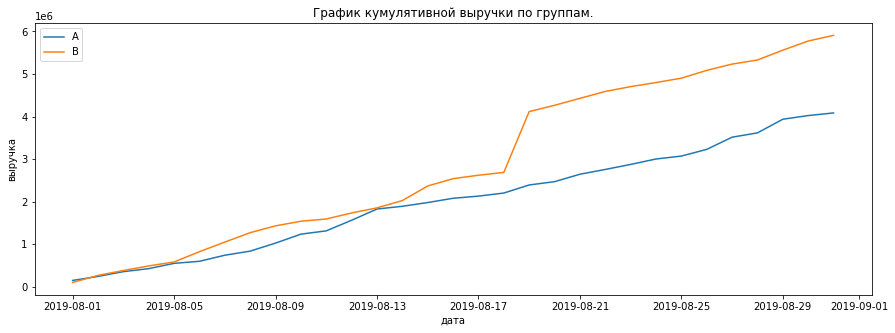

In [24]:
# Строим график выручки группы А

plt.figure(figsize=(15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title ('График кумулятивной выручки по группам.')
plt.xlabel('дата')
plt.ylabel('выручка')

plt.legend() 
plt.show()

In [25]:
# проверим диапазон дат

display(cumulativeData['date'].min())
display(cumulativeData['date'].max())

Timestamp('2019-08-01 00:00:00')

Timestamp('2019-08-31 00:00:00')

Изучаемый период - мес, с 01.08.2019 по 31.08.2019

На всем протяжении теста сегмент В лидировал, первую неделю теста разницы не было, затем выручка у обеих групп начала расти, но В рос несколько больше, затем был большой скачок у сегмента В и позитивный тренд до самого завершения теста, возможно были аномально дорогие заказы, которые так повлияли, чуть позже мы это проверим и удалим для чистоты анализа.

#### 4.2 График кумулятивного среднего чека по группам.

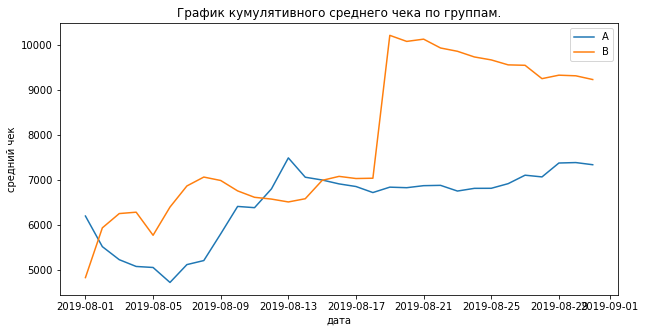

In [26]:
# строим график кумулятивного среднего чека по группам
plt.figure(figsize = (10,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.title ('График кумулятивного среднего чека по группам.')
plt.xlabel('дата')
plt.ylabel('средний чек')
plt.show()

Кумулятивные значения среднего чека несколько колеблются, однако в середине теста у сегмента В происходит существенный скачок за счет аномально высокого заказа,  уровень которого удержать, правда, не удается, но все равно остается значительно выше сегмента А. 

#### 4.3 График относительного изменения кумулятивного среднего чека группы B к группе A.

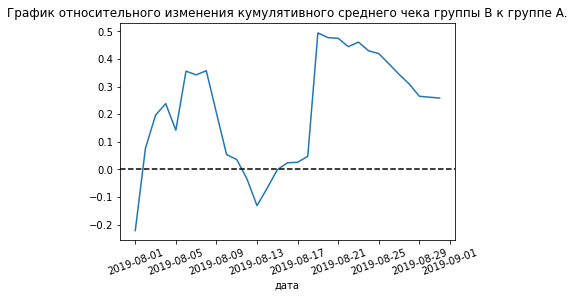

In [52]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title ('График относительного изменения кумулятивного среднего чека группы B к группе A.')

plt.xlabel('дата')
plt.xticks(rotation = 20)

plt.show()


Результаты теста менялись в одну дату, видимо тогда были аномальные заказы.

#### 4.4 График кумулятивной конверсии по группам.

In [28]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

display(cumulativeDataA.head())
display(cumulativeDataB.head())

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793


Посчитали кумулятивную конверсию по группам, вывели на экран.

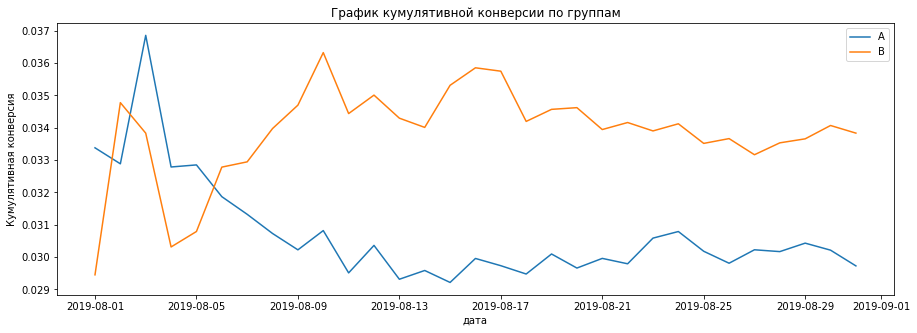

In [29]:
# строим графики
plt.figure(figsize=(15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

plt.title ('График кумулятивной конверсии по группам')

plt.xlabel('дата')
plt.ylabel('Кумулятивная конверсия')
plt.show()


Конверсия колебалась в обоих сегментах вначале теста, причем в группе А конверсия изначально была очень хорошой и был скачок, но уже на первой неделе группы поменялись местами и В опередил и выровнился около одного значения 3.5%, и по-прежнему больше значения сегмента А. Все колебания в пределах 1%. 

#### 4.5 График относительного изменения кумулятивной конверсии группы B к группе A.

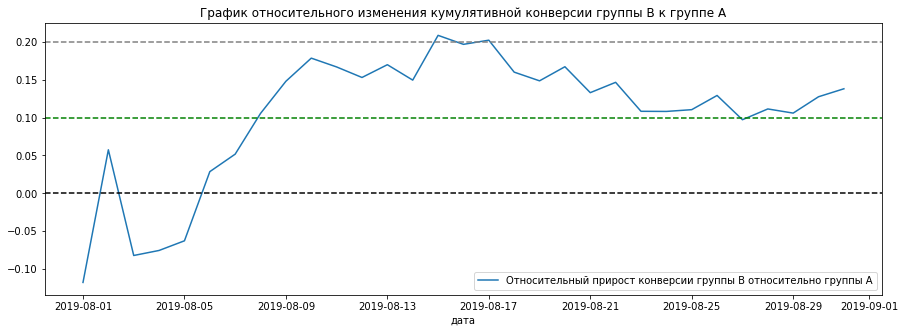

In [30]:
# объединим две переменные `cumulativeDataA` и `cumulativeDataB`
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])


#  построим график
plt.figure(figsize=(15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axhline(y=0.10, color='green', linestyle='--')

plt.title('График относительного изменения кумулятивной конверсии группы B к группе A')
plt.xlabel('дата')

plt.show()

В начале теста сегмент В был несколько хуже А, но затем уверенно становился лучше, ближе к завершению теста произошло незначительное снижение,на последней неделе колеблется в пределах 10% прироста относительно группы А.

#### 4.6 Количество заказов по пользователям.

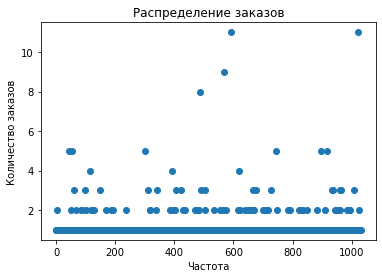

In [31]:
# сгруппируем данные Из `orders` по пользователям и посчитаем кол-во уникальных заказов на пользователя
ordersByUsers = orders.groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})
ordersByUsers.sort_values(by='transactionId', ascending=False).head()
x_values = pd.Series(range(0,len(ordersByUsers)))


# строим точечный график
plt.scatter(x_values, ordersByUsers['transactionId'])
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.title('Распределение заказов')
plt.xlabel('Частота')
plt.ylabel('Количество заказов')
plt.show()

Мы видим, что большинство пользователей совершили 1 заказ, но есть и 2, и 4 и даже 11, но не понятно, а сколько их таких, совершивших более 1 заказа. Для этого вы высчитаем перцентили и определим границы аномальных данных.

#### 4.7 95-й и 99-й перцентили количества заказов на пользователя.

In [32]:
# находим перцентили
print(np.percentile(ordersByUsers['transactionId'], [90,95,99]))

[1. 2. 4.]


 5% пользователей совершили 2 заказа, не более 1% совершили больше 4 заказов. За аномальных пользователей примем всех, кто совершил более 3 заказов, таким образом мы уберем 1% пользователей с наибольшим числом заказов.

#### 4.8 Стоимость заказов.

In [33]:
# выводим на экран отсортированную таблицу
display(orders.sort_values(by='revenue', ascending=False).head(10))
x_values = pd.Series(range(0,len( orders['revenue'])))


,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


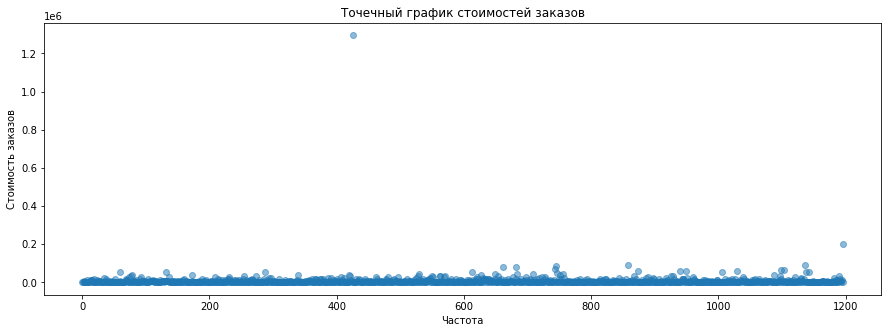

In [55]:
plt.figure(figsize=(15,5))
plt.scatter(x_values,  orders['revenue'], alpha=0.5)

plt.title('Tочечный график стоимостей заказов')


plt.xlabel('Частота')
plt.ylabel('Стоимость заказов')
plt.show()

  
Из-за одного явного выброса все значения слились в одну прямую, посмотрим на график без него.


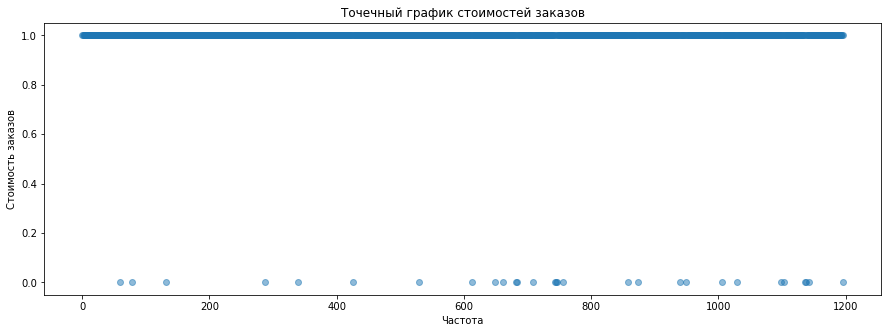

In [59]:
plt.figure(figsize=(15,5))
plt.scatter(x_values,  orders['revenue']< 40000, alpha=0.5)

plt.title('Tочечный график стоимостей заказов')


plt.xlabel('Частота')
plt.ylabel('Стоимость заказов')
plt.show()

Заказы в основном стоимостью до 10 000, единичны 20000 и 130 000. Стоимость заказа в интренет магазине 130 000 кажется очень странной.

#### 4.9 95-й и 99-й перцентили стоимости заказов

In [36]:
# находим перцентили
print(np.percentile(orders['revenue'], [90,95,99]))

[18168.  28000.  58233.2]


Максимум у 5% заказов чек дороже 28000, и не больше.чем у 1% заказов - дороже 58233. Примем за аномальные те, которые дороже 58000.


#### 4.10 Cтатистическая значимость 

##### 4.10.1 различий в конверсии между группами по «сырым» данным.

In [37]:
# вспоним датафрейм `visitors` 
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Создадим две переменные из `visitors` по группам А и В.

In [38]:
# создаем переменныt с количеством посетителей в день по группам

visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

display(visitorsADaily.head())
display(visitorsBDaily.head())

,date,visitorsPerDateA
0,2019-08-01,719
1,2019-08-02,619
2,2019-08-03,507
3,2019-08-04,717
4,2019-08-05,756


,date,visitorsPerDateB
31,2019-08-01,713
32,2019-08-02,581
33,2019-08-03,509
34,2019-08-04,770
35,2019-08-05,707


In [39]:
# вспоним датафрейм `orders` 
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [40]:
# создаем переменный с количеством заказов и их стоимости  в день по группам

ordersADaily = (orders[orders['group'] == 'A'][['date','transactionId','visitorId', 'revenue']]
              .groupby('date', as_index=False)
              .agg({'transactionId':pd.Series.nunique, 'revenue':'sum'}))

ordersADaily.columns = ['date','ordersPerDateA','revenuePerDateA']


ordersBDaily = (orders[orders['group'] == 'B'][['date','transactionId','visitorId', 'revenue']]
              .groupby('date', as_index=False)
              .agg({'transactionId':pd.Series.nunique, 'revenue':'sum'}))
ordersBDaily.columns = ['date','ordersPerDateB','revenuePerDateB']

display(ordersADaily.sort_values(by='revenuePerDateA', ascending=False).head())
display(ordersBDaily.sort_values(by='revenuePerDateB', ascending=False).head())


,date,ordersPerDateA,revenuePerDateA
28,2019-08-29,22,320690
26,2019-08-27,28,286780
12,2019-08-13,14,263638
11,2019-08-12,24,249190
9,2019-08-10,16,210495


,date,ordersPerDateB,revenuePerDateB
18,2019-08-19,21,1429920
14,2019-08-15,31,342499
5,2019-08-06,28,242342
28,2019-08-29,20,231130
6,2019-08-07,24,225334


In [41]:
# объединяем `ordersADaily`, `ordersBDaily`, `ordersADaily`, `ordersBDaily`
df= (ordersADaily.merge(ordersBDaily, left_on='date', right_on = 'date', how='left')\
    .merge(visitorsADaily, left_on = 'date', right_on = 'date', how='left')\
    .merge(visitorsBDaily, left_on = 'date', right_on = 'date', how='left'))
display(df.head())

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,visitorsPerDateA,visitorsPerDateB
0,2019-08-01,24,148579,21,101217,719,713
1,2019-08-02,20,93822,24,165531,619,581
2,2019-08-03,24,112473,16,114248,507,509
3,2019-08-04,16,70825,17,108571,717,770
4,2019-08-05,25,124218,23,92428,756,707


### 5. Проверка гипотез

### 5.1 Проверка гипотез по "сырым" данным

 #### 5.1.1 Гипотеза 1 - различия в конверсиях по "сырым" данным.
  Подготовили данные для тестирования. Нулевая гипотеза  - конверсии в группе В равны конверсиям в группе А. Гипотеза 1 - конерсии не равны. Уровень значимости  выбираем 0,05, проверять гипотезу будем критерием Манна-Уитни.

In [42]:
# создаем две отдельные переменные, сгруппированные по группам

ordersByUsersA = (orders[orders['group'] == 'A']
                  .groupby('visitorId', as_index = False).agg({'transactionId':'nunique'}))
ordersByUsersB = (orders[orders['group'] == 'B']
                  .groupby('visitorId', as_index = False).agg({'transactionId':'nunique'})) 
                  
sampleA = pd.concat([ordersByUsersA['transactionId'],pd.Series(0, index=np.arange(df['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])), name='transactionId')],axis=0)

sampleB = pd.concat([ordersByUsersB['transactionId'],pd.Series(0, index=np.arange(df['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])), name='transactionId')],axis=0)


                  
# расчитываем статистическую значимость различий в конверсии методом Манна_Уитни                  
        
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1]))

print('Относительный показатель B к A = {0:.3f}'.format(sampleB.mean() / sampleA.mean() - 1))               

p-value = 0.017
Относительный показатель B к A = 0.138


P-value 0.017 значительно меньше 0.05, поэтому нулевую гипотезу отвергаем. При анализе "сырых данных" видим, что в конверсии есть статистически значимые разлиция. Относительный прирост конверсии группы В к конверсии А равен  13.8%

#### 5.1.2 Гипотеза 2 - различия в среднем чеке заказа между группами по «сырым» данным. 

Проверка гипотезы
Подготовили данные для тестирования. Нулевая гипотеза - средние чеки в группе В равны средним чекам в группе А. Гипотеза 1 - средние чеки не равны. Уровень значимости выбираем 0,05, проверять гипотезу будем критерием Манна-Уитни.

In [43]:
# расчитываем статистическую значимость различий в среднем чеке методом Манна_Уитни     
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный показатель среднего чека B к A = {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.729
Относительный показатель среднего чека B к A = 0.259


P-value больше 0.05 - статистически значимых отличий в среднем чеке между группами нет. Тем не менее средний чек группы В превышает на 25,9%. 

### 5.2 Cтатистическая значимость по " очищенным" данным.

#### 5.2.1 Удаление "выбросов"

In [44]:
# выделяем аномальные данные
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['transactionId'] > 3]['visitorId'],
        ordersByUsersB[ordersByUsersB['transactionId'] > 3]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 58000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
display(abnormalUsers.shape[0])


1099    148427295
18      199603092
23      237748145
949     887908475
744     888512513
Name: visitorId, dtype: int64

20

In [45]:
# смотрим кол-во уникальных пользователей
orders['visitorId'].nunique()

1031

In [46]:
# высчитываем долю аномальных данных
deleted = round(abnormalUsers.shape[0]/orders['visitorId'].nunique(),3)
display(f' Доля удаленных данных {deleted}')

' Доля удаленных данных 0.019'

Доля удаленных данных составила 2%, это допустимо.


#### 5.2.2 Гипотеза 1 - различия в конверсиях

Проверка гипотезы после удаления аномальных данных.  
  Нулевая гипотеза - конверсии в группе В равны конверсиям в группе А. Гипотеза 1 - конверсии не равны. Уровень значимости выбираем 0,05, проверять гипотезу будем критерием Манна-Уитни.

In [47]:
# создаем 2 переменные и считаем статистическую значимость
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionId'])
            ),
            name='transactionId',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['transactionId'],
        pd.Series(
            0,
            index=np.arange(
                df['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionId'])
            ),
            name='transactionId',
        ),
    ],
    axis=0,
) 


print('Cтатистическая значимость различий в конверсии между группами = {0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

Cтатистическая значимость различий в конверсии между группами = 0.01390
0.151


P-value так же меньше , чем 0.05, как и в ситуации с сырыми данными, Сегмент В лучше,чем сегмент А.

#### 5.2.3 Гипотеза 2 - разлиция в средних чеках

Проверка гипотезы после удаления аномальных данных.  
  Нулевая гипотеза - средний чек в группе В равны конверсиям в группе А. Гипотеза 1 - средние чеки не равны. Уровень значимости выбираем 0,05, проверять гипотезу будем критерием Манна-Уитни.

In [48]:
print('Cтатистическая значимость различий в среднем чеке заказа между группами ={0:.3f}'\
      .format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('{0:.3f}'\
      .format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Cтатистическая значимость различий в среднем чеке заказа между группами =0.959
-0.014


P-value больше 0.05, значит мы не можем говорить о наличии различий в среднем чеке, средний чек группы В ниже на 1.4%

### Вывод

В  данном исследовании перед нами было две глобальные задачи: 1. приоритизация гипотез и 2. анализ А/В теста.

1. Приоритизация гипотез.  
  Применив фреймворки ICE и RICE мы приоритизировали наши 9 гипотез и получили при этом разный список приоритетов, что является нормальным явлением. Так по ICE топ-4 гипотез: 8,0,7,6, а по RICE - 7,2,0,6. Итак первая гипотеза по RICE 7 сместила 8 гипотезу за счет высокого параметра Reach, который равен 10, и появилась другая гипотеза под номером 2  так же за счет относительно высокого показаетля Reach 8 и низкого Efforts, равному 3.  

2. Анализ А/В теста.
* Есть статистически значимые отличия в конверсии, что в "сырых", что в "очищенных" данных.
* Статистическая разница в среднем чеке появляется только после удаления аномалий. Однако при "сырых" данных средний чек группы В на 25,9% превышает А, а после отброса аномалий средний чек стал меньше на 1.4%. То есть заказы стали более дешевые, но больше по кол-ву выкупленных.
* График различия конверсий между группами показывает, что ближе к завершению теста произошло незначительное снижение после большого скачка,на последней неделе колеблется в пределах 10% прироста относительно группы А и имеет положительную динамику.



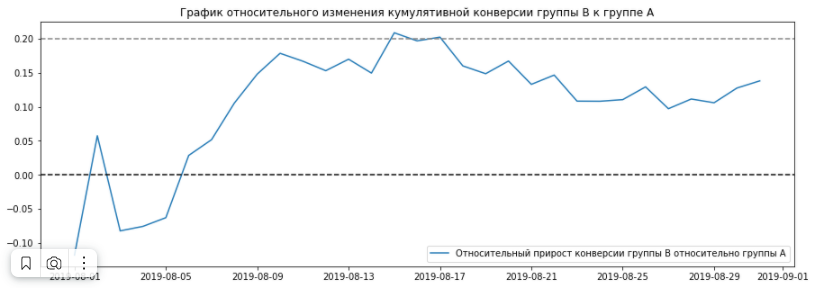

* График различия среднего чека колеблется, сделать конкретные выводы по нему нельзя.  
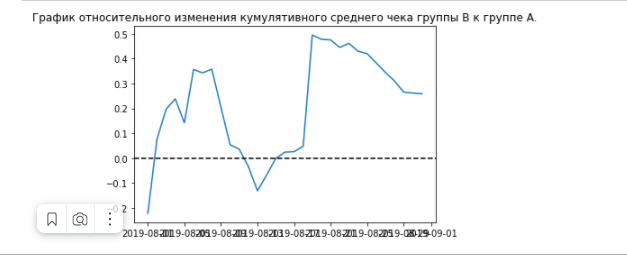


Тест был успешным, группа В статистически значимо лучше группы А по обеим метрикам, конверсия говорит о фиксации результат с положительной динамикой.
  